In [1]:
'''
This notebook focuses on pre-processing and creating a baseline model to improve upon
Pre-processing includes:
 - Dummy encoding
 - Imputation 
     - mean, median, mode and KNN -> Mean used in end
 - (Removal of columns with high missing variables) -> found does not work well
 
Logistic regression model  (no optimisation)
Logistic regression model  (with basic random search optimisation)

Best ROC AUC on test set -> 73.846%
'''

'\nThis notebook focuses on pre-processing and creating a baseline model to improve upon\nPre-processing includes:\n - Dummy encoding\n - Imputation\n - Removal of columns with high missing variables\n\nLogistic regression model applied (no optimisation)\nAccuracy -> ___%\n'

In [1]:
# numpy and pandas for data manipulation
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Imputer

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor


In [2]:
def save_pickle(path, data):
    # pickles the tokens dict
    with open(path, "wb") as f:
        pickle.dump(data, f)
    print("File saved at ", path)


def load_pickle(path):
    # loads the tokens dict from directory
    with open(path, "rb") as f:
        return pickle.load(f)
    print("File loaded: ", path)

In [3]:
def load_training_data():
    app_train = pd.read_csv('../input/application_train.csv')
    print('Training data shape: ', app_train.shape)
    return app_train


def load_test_data():
    # Testing data features
    app_test = pd.read_csv('../input/application_test.csv')
    print('Testing data shape: ', app_test.shape)
    return app_test

train_data = load_training_data()
test_data = load_test_data()

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [4]:
def encode_binary_cols(app_train, app_test):
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0
    encoded_cols = []
    # Iterate through the columns
    for col in app_train:
        if app_train[col].dtype == 'object':
            # If 2 or fewer unique categories (a nan will count as a category)
            if len(list(app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(app_train[col])
                # Transform both training and testing data
                app_train[col] = le.transform(app_train[col])
                app_test[col] = le.transform(app_test[col])
                encoded_cols.append(col)

                # Keep track of how many columns were label encoded
                le_count += 1
    return app_train, app_test
                
train_data, test_data = encode_binary_cols(train_data, test_data)

In [5]:
def one_hot_encode(app_train, app_test):
    # one-hot encoding of categorical variables
    # Dummy encoding will not create a column for nans
    app_train = pd.get_dummies(app_train)
    app_test = pd.get_dummies(app_test)

    print("ONE HOT ENCODED")
    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    return app_train, app_test

train_data, test_data = one_hot_encode(train_data, test_data)

ONE HOT ENCODED
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [6]:
def align_data(app_train, app_test):
    # ALIGN TEST AND TRAIN DATAFRAMES SO COLUMNS MATCH
    train_labels = app_train['TARGET']

    # Align the training and testing data, keep only columns present in both dataframes
    app_train, app_test = app_train.align(app_test, join='inner', axis=1)

    # Add the target back in
    app_train['TARGET'] = train_labels

    print("ALIGNED:")
    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    return app_train, app_test, train_labels

train_data, test_data, train_Y = align_data(train_data, test_data)

ALIGNED:
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


There were 9274 anomalies in the test data out of 48744 entries


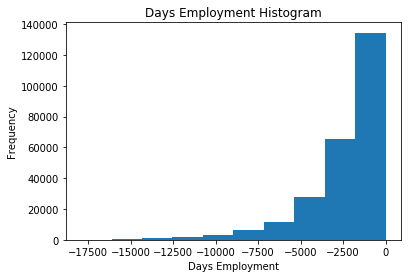

In [7]:
def remove_days_employed_anomaly(app_train, app_test):
    # DEALING WITH ANOMALOUS DATA IN 'DAYS_EMPLOYED' COL

    # Create an anomalous flag column
    app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
    # Replace the anomalous values with nan
    app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

    app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram');
    plt.xlabel('Days Employment');

    app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
    app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

    print('There were %d anomalies in the test data out of %d entries' % (
        app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))
    return app_train, app_test

train_data, test_data = remove_days_employed_anomaly(train_data, test_data)

In [10]:
'''
Best Penalty: l2
Best C: 0.7450408455106836
Score - 0.73806
Approx 20 mins train time
'''
def remove_missing_cols(app_train, app_test, thr=0.68):

    app_train = app_train.loc[:, app_train.isnull().mean() < thr] #remove all columns with more than x% missing values 
    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)

    # ALIGN TEST AND TRAIN DATAFRAMES SO COLUMNS MATCH
    train_labels = app_train['TARGET']
    # Align the training and testing data, keep only columns present in both dataframes
    app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
    # Add the target back in
    app_train['TARGET'] = train_labels

    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    return app_train, app_test
    
# train_data, test_data = remove_missing_cols(train_data, test_data)

Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 240)
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)


In [13]:
def normalise_and_impute(app_train, app_test, impute_strategy='mean'):
    # Drop the target from the training data
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
    else:
        train = app_train.copy()
    train = train.drop(columns=['SK_ID_CURR'])  #

    test = app_test.copy()
    test = test.drop(columns=['SK_ID_CURR'])  #

    # Feature names
    features = list(train.columns)

    # Median imputation of missing values
    imputer = Imputer(strategy=impute_strategy)
    # Fit on the training data
    imputer.fit(train)
    # Transform both training and testing data
    train = imputer.transform(train)
    test = imputer.transform(test)  ### test was app_test

    # Normalise
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale each feature to 0-1
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    print("IMPUTED AND NORMALISED")
    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)
    return train, test, features

# train_X and test_X are np arrays
# train_X, test_X, feature_names = normalise_and_impute(train_data, test_data, impute_strategy='mean')

IMPUTED AND NORMALISED
Training data shape:  (307511, 230)
Testing data shape:  (48744, 230)


In [12]:
def create_and_save_submission(app_test, predictions, save_path):
    # Submission dataframe
    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = predictions

    # Save the submission to a csv file
    submit.to_csv(save_path, index=False)
    print("Predictions saved to: ", save_path)

In [16]:
def baseline_log_reg(train, train_Y, test, save_path):
    # Make the model with the specified regularization parameter
    log_reg = LogisticRegression(C=0.0001)

    # Train on the training data
    log_reg.fit(train, train_Y)

    # Make predictions - only require 2nd columns (representing the probability that the target is 1)
    log_reg_pred = log_reg.predict_proba(test)[:, 1]

    # Save model
    save_pickle(save_path, log_reg)  # save model
    print("Log reg baseline model saved to: ", save_path)
    return log_reg, log_reg_pred

model, preds = baseline_log_reg(train_X, train_Y, test_X, save_path="../models/test.pickle")
create_and_save_submission(test_data, preds, save_path='../test_predictions/test.csv')

File saved at  ../models/test.pickle
Log reg baseline model saved to:  ../models/test.pickle
Predictions saved to:  ../test_predictions/test.csv


In [15]:
def random_search_log_reg(train, train_Y, test, save_path):
    '''
    Mean imputation
    Best Penalty: l2
    Best C: 1.668088018810296
    test acc -> 0.73846
    '''
    model = LogisticRegression()

    # Search parameters and search space
    penalty = ['l1', 'l2']
    C = uniform(loc=0, scale=4)
    hyperparameters = dict(C=C, penalty=penalty)

    # Create randomized search 5-fold cross validation and 100 iterations
    clf = RandomizedSearchCV(model, hyperparameters, random_state=1, n_iter=10, cv=3, verbose=3, n_jobs=10) # will take a while to run
    # Fit randomized search
    best_model = clf.fit(train, train_Y)

    print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C:', best_model.best_estimator_.get_params()['C'])

    predictions = best_model.predict_proba(test)[:, 1]

    # Save model
    save_pickle(save_path, best_model)  # save model
    print("Log reg baseline model saved to: ", save_path)

    return model, predictions

# model, preds = random_search_log_reg(train_X, train_Y, test_X, save_path="../models/log_reg_drop_rs_tuned.pickle")
# create_and_save_submission(test_data, preds, save_path='../test_predictions/log_reg_drop_rs_tuned.csv')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed: 13.9min remaining:  5.1min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 16.0min finished


Best Penalty: l2
Best C: 0.7450408455106836
File saved at  ../models/log_reg_new.pickle
Log reg baseline model saved to:  ../models/log_reg_drop_rs_tuned.pickle
Predictions saved to:  ../test_predictions/log_reg_drop_rs_tuned.csv


In [13]:
def cross_val_roc_curve(train_X, train_Y, classifier):
    # From https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

    # ROC AUC with stratified cross validation
    X = train_X
    y = train_Y

    cv = StratifiedKFold(n_splits=6, shuffle=True)
    tprs = []  # true positive rate scores
    aucs = []  # area under curve scores
    mean_fpr = np.linspace(0, 1, 100)  # mean false positive rates

    i = 0
    # train and test for each fold
    for train_sample, test_sample in cv.split(X, y):
        probas_ = classifier.fit(X[train_sample], y[train_sample]).predict_proba(X[test_sample])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test_sample], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        print("Run {} AUC socre: {}".format(i, roc_auc))

        '''Everything below this point is just for the plot'''
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    # plot roc curve for fold
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    # caluclate and plot mean auc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # plot standard deviation area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # add labels to plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    print("Avg ROC AUC score: {}".format(np.mean(aucs)))

# model = load_pickle("../models/log_reg_opt.pickle")
# train_X, test_X, feature_names = normalise_and_impute(train_data, test_data, impute_strategy='mean')
# cross_val_roc_curve(train_X, train_Y, model) 

In [14]:
def feature_aic_bic(app_train, feature_name: str):
    # calculates the aic and bic values between the target and a column
    # http://www.differencebetween.net/miscellaneous/difference-between-aic-and-bic/

    data = app_train.copy()
    data = data[[feature_name, "TARGET"]]

    # Median imputation of missing values
    imputer = Imputer(strategy='mean')
    imputer.fit(data)
    imputed_data = imputer.transform(data)
    data[feature_name] = imputed_data

    data["intercept"] = 1.0
    logit = sm.Logit(data["TARGET"], data[feature_name])
    result = logit.fit()

    # result.summary2() # uncomment for full summary
    print("Selected Feature", feature_name)
    print("AIC", result.aic)
    print("BIC", result.bic)

    # 168863, 0.274561 - ext3 mean
# model = load_pickle("../models/log_reg_opt.pickle")
# feature_aic_bic(train_data, "EXT_SOURCE_3")

In [15]:
def imputed_col_aic(data, feature_name):
#     data["intercept"] = 1.0
    logit = sm.Logit(data["TARGET"], data[feature_name])
    result = logit.fit()
    print("AIC", result.aic)

In [16]:
def get_top_correlations(app_train, feature, n=15):
    correlations = app_train.corr()[feature]
    correlations = abs(correlations).sort_values().tail(
        n)  # sort by correlation value (regardless if it's positive or negative)
    correlations = correlations.dropna()  # drop nans
    if 'TARGET' in correlations:
        correlations = correlations.drop(labels=[feature, 'TARGET'])  # remove corr to itself and target
    return correlations



In [17]:
def save_all_correlations(app_train):
    path = '../models/correlations/'
    for feature in train_data.columns[:]:
        correlations = app_train.corr()[feature]
        if '/' in feature or ':' in feature:
            # replace / and : with '' -> as they are invalid characters for filename 
            feature = feature.replace('/','')
            feature = feature.replace(':','')
        save_pickle(path+feature+'.pickle', correlations)
    print("ALL CORRELATIONS SAVED")

def top_correlations_from_all(feature:str, n):
    path = '../models/correlations/'
    filename = feature
    if '/' in filename or ':' in filename:
            # replace / and : with '' -> as they are invalid characters for filename 
            filename = filename.replace('/','')
            filename = filename.replace(':','')
            
    correlations = load_pickle(path+feature+'.pickle')
    correlations = abs(correlations).sort_values().tail(n)  # sort by correlation value (regardless if it's positive or negative)
    correlations = correlations.dropna()  # drop nans
    if 'TARGET' in correlations:
        correlations = correlations.drop(labels=[feature, 'TARGET'])  # remove corr to itself and target
    return correlations
    
# save_all_correlations(train_data)
# train_data.columns[181:][0].replace('/', '')


In [49]:
def top_corr_knn_imputation(feature, train, test, train_filled, test_filled,n_jobs):
    top_corrs = top_correlations_from_all(feature, 15).keys()
    
    # create training data from columns with values
    not_null_mask = train[feature].notna()  # true if not nan = mask to get the values to train on
    knn_train_x = train_filled[not_null_mask][top_corrs] # get all top corr cols (minus target) which have a feature value
    knn_train_y = train_filled[not_null_mask][[feature]]
    
    # get the rows which require to be imputed for the features
    knn_test_x = train_filled[train[feature].isna()][top_corrs]  # only null values
    actual_test_x = test_filled[test[feature].isna()][top_corrs]  # only null values
    
    # train and predict
    filename = feature.replace(':', '')
    fileaname = feature.replace('/', '')
    try:
        neigh = load_pickle("../models/knn_corrs_rs_clf/"+filename+".pickle")
    except FileNotFoundError:
        print("Training col:", feature)
    #     neigh = KNeighborsRegressor(n_neighbors=75)
        model = KNeighborsRegressor()
        n_neighbors = range(10,200)
        hyperparameters = dict(n_neighbors=n_neighbors)
        neigh = RandomizedSearchCV(model, hyperparameters, n_iter=7, cv=3, verbose=3, n_jobs=n_jobs)
        neigh.fit(knn_train_x, knn_train_y)
        save_pickle("../models/knn_corrs_rs_clf/"+filename+".pickle", neigh)
        
    print('Best n_neigbors:', neigh.best_estimator_.get_params()['n_neighbors'])
    knn_test_y = neigh.predict(knn_test_x)
    # get the column to update nulls
    train_imputed_col = train[[feature]]
    train_imputed_col[train_imputed_col[feature].isna()] = knn_test_y
    
    # the train data has more unfilled cols than test, so something imputation is not required
    try:
        actual_test_y = neigh.predict(actual_test_x)
        # get the column to update nulls for app_test
        test_imputed_col = test[[feature]]
        test_imputed_col[test_imputed_col[feature].isna()] = actual_test_y
    except ValueError:
        test_imputed_col = test[[feature]]
    
    return train_imputed_col, test_imputed_col


(307511, 62)

In [47]:
def impute_knn(app_train, app_test, n_jobs):
    count = 1
    train_nan_cols = app_train.loc[:,app_train.isnull().any()]
    test_nan_cols = app_test.loc[:,app_test.isnull().any()]
    
    train_full_impute = app_train.copy()
    train_full_impute = train_full_impute.fillna(train_full_impute.mean())
    test_full_impute = app_test.copy()
    test_full_impute  = test_full_impute.fillna(train_full_impute.mean())

    print(list(train_nan_cols))
#     for col in train_nan_cols.columns[54:]: # TODO - remove index once done
    for col in train_nan_cols: # TODO - remove index once done
        imputed_train, imputed_test = top_corr_knn_imputation(col, app_train, app_test, train_full_impute, test_full_impute, n_jobs=n_jobs)
        app_train[col] = imputed_train
        app_test[col] = imputed_test
        print("{} out of {} done - col: {}".format(count, test_nan_cols.shape[1], col))
        count += 1
            
    return app_train, app_test



In [50]:
def log_reg_knn_imputation( app_train, app_test, model_save_path, predications_save_path, n_jobs):
    train, test = impute_knn(app_train, app_test, n_jobs=n_jobs)
#     save_pickle("../models/knn_impute_train_df1.pickle", train)
#     save_pickle("../models/knn_impute_test_df1.pickle", test)
    train = load_pickle("../models/knn_impute_train_df.pickle")
    test = load_pickle("../models/knn_impute_test_df.pickle")
    train_Y = train['TARGET']

    train = train.drop(columns=train.loc[:,train.isnull().any()].columns)  #
    trian, test, train_Y = align_data(train,test)
    # Drop the target and sk_id_curr from the training data
    if 'TARGET' in train:
        train = train.drop(columns=['TARGET'])
    train = train.drop(columns=['SK_ID_CURR'])  #
    test = test.drop(columns=['SK_ID_CURR'])  #
    
    model, preds = baseline_log_reg(train, train_Y, test, save_path=model_save_path)
    create_and_save_submission(test_data, preds, save_path=predications_save_path)

    
# log_reg_knn_imputation(train_data.copy(), test_data.copy(),
#                        model_save_path="../models/knn_imputation_top_corr_log_reg1.pickle",
#                        predications_save_path='../test_predictions/knn_imputation_top_corr_log_reg1.csv',
#                        n_jobs=10) 


['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI'

In [22]:
# from sklearn.preprocessing import MinMaxScaler, Imputer
# import statsmodels.api as sm
# from sklearn.decomposition import PCA
# from sklearn.manifold import Isomap
# from sklearn.neighbors import KNeighborsRegressor

# def log_reg_pca_knn_imputation(feature):
#     col = app_train[[feature]]

#     not_null_mask = app_train[feature].notna() # true if not nan = mask to get the values to train on 
#     train_x = app_train[not_null_mask] # get all top corr cols (minus target) which have a ext_source_3 value
# #     train_x = train_x.drop(columns = [chosen_col, 'SK_ID_CURR', "TARGET"])
#     train_x = train_x.drop(columns = [chosen_col])
#     train_y = app_train[not_null_mask][[chosen_col]] 

#     # get the rows which require imputation
#     test_x = app_train[app_train[chosen_col].isna()] #only null values
#     test_x = test_x.drop(columns = [chosen_col, 'TARGET'])

#     train_x, test_x, feats_names = normalise_and_impute(train_x, test_x)
# #     # Median imputation of missing values
# #     imputer = Imputer(strategy = 'mean')
# #     imputer.fit(train_x)
# #     train_x = imputer.transform(train_x)
# #     test_x = imputer.transform(test_x)

# #     # Scale each feature to 0-1
# #     scaler = MinMaxScaler(feature_range = (0, 1))
# #     scaler.fit(train_x)
# #     train_x = scaler.transform(train_x)
# #     test_x = scaler.transform(test_x)

#     pca = PCA(n_components=30, svd_solver='full')
#     pca.fit(train_x)
#     train_x = pca.transform(train_x)
#     test_x = pca.transform(test_x)
#     print("Captured variance", pca.explained_variance_ratio_.sum())


#     # train and predict
#     neigh = KNeighborsRegressor(n_neighbors=10)
#     neigh.fit(train_x,train_y)
#     y_test = neigh.predict(test_x)

#     # get the column to update nulls
#     filled_col = app_train[[chosen_col]]
#     filled_col[filled_col[chosen_col].isna()] = y_test


#     col = "EXT_SOURCE_3"
#     # Drop the target from the training data
#     data = app_train.copy()
#     data = data[[col,"TARGET"]]
#     data[col] = filled_col

#     cols_to_keep = ["TARGET", col]
#     data["intercept"] = 1.0
#     train_cols = data.columns[1:]
#     logit = sm.Logit(data["TARGET"], data[col])
#     result = logit.fit()


In [23]:
# # from sklearn.preprocessing import MinMaxScaler, Imputer
# # import statsmodels.api as sm
# # from sklearn.decomposition import PCA
# # from sklearn.manifold import Isomap
# # from sklearn.neighbors import KNeighborsRegressor


# def pca_knn_imputation(feature, train, test, train_filled, test_filled,n_jobs):
#     top_corrs = top_correlations_from_all(feature, 15).keys()
    
#     # create training data from columns with values
#     not_null_mask = train[feature].notna()  # true if not nan = mask to get the values to train on
#     knn_train_x = train_filled[not_null_mask][top_corrs] # get all top corr cols (minus target) which have a feature value
#     knn_train_y = train_filled[not_null_mask][[feature]]
    
#     # get the rows which require to be imputed for the features
#     knn_test_x = train_filled[train[feature].isna()][top_corrs]  # only null values
#     actual_test_x = test_filled[test[feature].isna()][top_corrs]  # only null values
    
#     pca = PCA(n_components=30, svd_solver='full')
#     pca.fit(knn_train_x)
#     train_x = pca.transform(knn_train_x)
#     test_x = pca.transform(knn_train_y)
#     test_x = pca.transform(actual_test_x)
#     print("Captured variance", pca.explained_variance_ratio_.sum())

#     # train and predict
#     filename = feature.replace(':', '')
#     fileaname = feature.replace('/', '')
#     print("DOING Feature ", feature)
#     try:
#         neigh = load_pickle("../models/knn_corrs_rs_clf/"+filename+".pickle")
#         print("loaded knn")
#     except FileNotFoundError:
#     #     neigh = KNeighborsRegressor(n_neighbors=75)
#         model = KNeighborsRegressor()
#         n_neighbors = range(10,200)
#         hyperparameters = dict(n_neighbors=n_neighbors)
#         neigh = RandomizedSearchCV(model, hyperparameters, n_iter=7, cv=3, verbose=3, n_jobs=n_jobs)
#         neigh.fit(knn_train_x, knn_train_y)
#         save_pickle("../models/knn_corrs_rs_clf/"+filename+".pickle", neigh)
        
#     print('Best n_neigbors:', neigh.best_estimator_.get_params()['n_neighbors'])
#     knn_test_y = neigh.predict(knn_test_x)
#     actual_test_y = neigh.predict(actual_test_x)
    
#     # get the column to update nulls
#     train_imputed_col = train[[feature]]
#     train_imputed_col[train_imputed_col[feature].isna()] = knn_test_y
    
#     # get the column to update nulls for app_test
#     test_imputed_col = test[[feature]]
#     test_imputed_col[test_imputed_col[feature].isna()] = actual_test_y
    
#     return train_imputed_col, test_imputed_col

In [24]:
# def top_corr_knn_imputation(top_corrs, feature: str, app_train, app_test):
# #     top_corrs = get_top_correlations(train_data, feature, n=10)  # TODO -> uncomment once working
# #     top_corrs = load_pickle('../models/correlations/'+feature+'.pickle', n=10)
# #     top_corrs = top_correlations_from_all(top_corrs)
    
#     # create training data from columns with values
#     not_null_mask = app_train[feature].notna()  # true if not nan = mask to get the values to train on
#     train_x = app_train[not_null_mask][top_corrs]  # get all top corr cols (minus target) which have a ext_source_3 value
#     train_y = app_train[not_null_mask][[feature]]

#     # imputation of missing values for the other columns
#     imputer = Imputer(strategy='mean')
#     train_x = imputer.fit_transform(train_x)

#     # get the rows which require imputation for the rest of the columns 
#     test_x = app_train[app_train[feature].isna()][top_corrs]  # only null values
#     imputer = Imputer(strategy='mean')
#     test_x = imputer.fit_transform(test_x)

#     # as above but for the app_test data
#     app_test_x = app_test[app_test[feature].isna()][top_corrs]  # only null values
#     imputer = Imputer(strategy='mean')
#     app_test_x = imputer.fit_transform(app_test_x)

#     # train and predict
#     neigh = KNeighborsRegressor(n_neighbors=150)
#     neigh.fit(train_x, train_y)
#     y_test = neigh.predict(test_x)
#     y_app_test = neigh.predict(app_test_x)

#     # get the column to update nulls
#     filled_col = app_train[[feature]]
#     filled_col[filled_col[feature].isna()] = y_test
#     # fill column
#     data = app_train.copy()
#     data[feature] = filled_col

#     # get the column to update nulls for app_test
#     filled_col_app_test = app_test[[feature]]
#     filled_col_app_test[filled_col_app_test[feature].isna()] = y_app_test
#     # fill column
#     data_app_test = app_test.copy()
#     data_app_test[feature] = filled_col_app_test
    
#     #calc aic score from single col imputation
#     imputed_col_aic(data, feature)
    
#     return data, data_app_test

In [25]:
# def log_reg_knn_imputation(top_corrs, feat_name, app_train, app_test, model_save_path, predications_save_path):
# #     top_corrs = get_top_correlations(train_data, 'EXT_SOURCE_3', n=15)
#     train_Y = app_train['TARGET']
#     train_X, test_X = top_corr_knn_imputation(top_corrs, feat_name, app_train, app_test)
#     train_X, test_X, feat_names = normalise_and_impute(train_X, test_X,
#                                                        impute_strategy='mean')

#     model, preds = baseline_log_reg(train_X, train_Y, test_X, save_path=model_save_path)
#     create_and_save_submission(test_data, preds, save_path=predications_save_path)

    
# log_reg_knn_imputation(top_corrs, 'EXT_SOURCE_3', train_data, test_data,
#                        model_save_path="../models/test.pickle",
#                        predications_save_path='../test_predictions/test.csv') 
# # test score -> 0.67843 (using baseline params)